In [29]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as data

train_transform =transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5,))
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=train_transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)
train_loader = data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

100.0%
100.0%
100.0%
100.0%


In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import math

class SinusoidalPositionEmbedBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings
    
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, base_size = 64):
        super(UNet, self).__init__()
        t_dim = 8
        # Encoder (Downsampling)
        self.enc1 = self.conv_block(in_channels, base_size)
        self.enc2 = self.conv_block(base_size, 2*base_size)
        self.enc3 = self.conv_block(2*base_size, 4*base_size)

        # Bottleneck
        self.bottleneck = self.conv_block(4*base_size, 8*base_size)
        self.sinusoidal_time = SinusoidalPositionEmbedBlock(t_dim)
        self.embedding_1 = nn.Sequential(
            nn.Linear(t_dim, 2*base_size),
            nn.GELU(),
            nn.Linear(2*base_size, 2*base_size),
            nn.GELU(),
        )
        self.embedding_2 = nn.Sequential(
            nn.Linear(t_dim, 4*base_size),
            nn.GELU(),
            nn.Linear(4*base_size, 4*base_size),
            nn.GELU(),
        )
        # Decoder (Upsampling)
        self.up3 = self.up_sample(8*base_size,4*base_size)
        self.up_conv3 = self.conv_block(8*base_size, 4*base_size)
        self.up2 = self.up_sample(4*base_size, 2*base_size)
        self.up_conv2 = self.conv_block(4*base_size,2*base_size)
        self.up1 = self.up_sample(2*base_size,base_size)
        self.up_conv1 = self.conv_block(2*base_size, base_size)

        # Final Output Layer
        self.final_conv = nn.Conv2d(base_size, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        """Convolutional block: 2 conv layers + ReLU"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),  # Batch normalization
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),                
            nn.BatchNorm2d(out_channels),  # Batch normalization
            nn.GELU()
        )

    def up_sample(self, in_channels, out_channels):
        """Upsampling + Convolution"""
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        )

    def forward(self, x,t):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(F.max_pool2d(e1, kernel_size=2, stride=2))
        e3 = self.enc3(F.max_pool2d(e2, kernel_size=2, stride=2))

        # Bottleneck
        b = self.bottleneck(F.max_pool2d(e3, kernel_size=2, stride=2))
        t = self.sinusoidal_time(t)
        temb1 = (self.embedding_1(t))
        temb1 = temb1.view(temb1.shape[0], temb1.shape[1], 1, 1)
        temb2 = self.embedding_2(t)
        temb2 = temb2.view(temb2.shape[0], temb2.shape[1], 1, 1)
        # Decoder with Skip Connections
        d3 = self.up3(b)  # upsample
        d3 = torch.cat([d3,e3],dim=1) #skip connection
        d3 = self.up_conv3(d3) #convolution
        d2 = self.up2(d3+temb2)  # upsample
        d2 = torch.cat([d2,e2],dim=1) #skip connection
        d2 = self.up_conv2(d2) #convolution
        d1 = self.up1(d2+temb1)  # upsample
        d1 = torch.cat([d1,e1],dim=1) #skip connection
        d1 = self.up_conv1(d1) #convolution

        # Final output layer
        
        return self.final_conv(d1)
    
    

In [35]:
class Diffusion(nn.Module):
    def __init__(self, timesteps=1000, img_size=32):
        super(Diffusion, self).__init__()
        self.timesteps = timesteps
        self.img_size = img_size
        self.betas = (torch.linspace(0.0001**0.5, 0.02**0.5, timesteps) ** 2).to(device)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas,dim=0)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
    def forward(self, x_0, t, noise = None):
        if noise is None:
            noise = torch.randn_like(x_0)
        sqrt_alpha_cumprod_t = self.sqrt_alphas_cumprod[t].reshape(-1, 1, 1, 1)
        sqrt_one_minus_alpha_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t].reshape(-1, 1, 1, 1)
        return sqrt_alpha_cumprod_t * x_0 + sqrt_one_minus_alpha_cumprod_t * noise, noise
        

In [36]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter


import datetime
now = datetime.datetime.now().strftime("%m_%d-%H_%M_%S")

writter = SummaryWriter(log_dir=f'runs/diffusion/{now}')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet().to(device)
diffusion = Diffusion().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 5

for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, (images, _) in enumerate(train_loader):
        images = images.to(device)
        optimizer.zero_grad()
        t = torch.randint(0, diffusion.timesteps, (images.shape[0],), device=device).long()
        x_t, noise = diffusion(images, t)
        predicted_noise = model(x_t,t)

        loss = F.mse_loss(predicted_noise, noise)
        writter.add_scalar("Loss/train",loss, batch_idx + len(train_loader) * epoch)
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    writter.flush()
    print(f"Epoch {epoch+1}: Loss {total_loss/len(train_loader)}")
    writter.close()

Epoch 1: Loss 0.1064039142305917
Epoch 2: Loss 0.06646894409394721
Epoch 3: Loss 0.05902246085962634
Epoch 4: Loss 0.056753809943096215
Epoch 5: Loss 0.05308526950572599


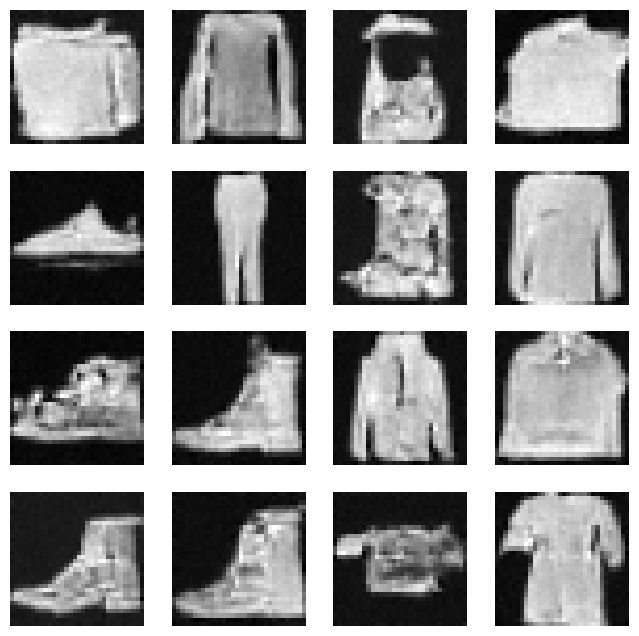

In [37]:

import matplotlib.pyplot as plt

@torch.no_grad()
def sample(model, diffusion, num_samples=16):
    model.eval()
    x_t = torch.randn((num_samples, 1, 32, 32), device=device)
    
    for t in reversed(range(diffusion.timesteps)):
        t_tensor = torch.full((num_samples,), t, device=device, dtype=torch.long)
        predicted_noise = model(x_t,t_tensor)
        
        # Compute the mean of p(x_{t-1} | x_t)
        alpha_t = diffusion.alphas[t_tensor].reshape(-1, 1, 1, 1)
        alpha_cumprod_t = diffusion.alphas_cumprod[t_tensor].reshape(-1, 1, 1, 1)
        mean = (1 / torch.sqrt(alpha_t)) * (x_t - (1 - alpha_t) / torch.sqrt(1 - alpha_cumprod_t) * predicted_noise)

        if t > 0:
            z = torch.randn_like(x_t)
            sigma_t = torch.sqrt(diffusion.betas[t_tensor]).reshape(-1, 1, 1, 1)
            x_t = mean + sigma_t * z
        else:
            x_t = mean

    return x_t

# Generate and visualize samples
samples = sample(model, diffusion)
samples = samples.cpu().numpy().squeeze()

fig, axs = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(samples[i], cmap="gray")
    ax.axis("off")
plt.show()